In [50]:
!pip install tf-keras-vis

In [51]:
## load package
%reload_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tf_keras_vis.utils import num_of_gpus
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from sklearn.model_selection import train_test_split
_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


### Load tf.keras.Model

In this notebook, we use VGG16 model, but if you want to use other tf.keras.Model, you can do so by modifying the section below.

In [52]:
from tensorflow.keras.applications import EfficientNetV2B0 as Model

model = Model(weights='imagenet', include_top=True)
model.compile(
        loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.01), metrics=["accuracy"]
    )
model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_8 (Rescaling)     (None, 224, 224, 3)          0         ['input_8[0][0]']             
                                                                                                  
 normalization_5 (Normaliza  (None, 224, 224, 3)          0         ['rescaling_8[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalizatio

### Load and preprocess images

tf-keras-vis supports batch-wise visualization. Here, we load and preprocess three pictures of goldfish, bear and assault-rifle as input data.

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
image_path = "/content/drive/MyDrive/Subset_1-40_81-120/Image_subset_032224"
SG_path = "/content/drive/MyDrive/Subset_1-40_81-120/Explanation/SG/"

In [55]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.model_selection import train_test_split


In [56]:
from PIL import Image

def change_size_for_model(image):
    image = Image.fromarray(image)
    resized_image = image.resize((224, 224))
    resized_array = np.array(resized_image)
    return resized_array.astype(np.uint8)

def change_size_for_original(image, original_shape):
    image = Image.fromarray(image)
    resized_image = image.resize(original_shape) #resize image
    resized_array = np.array(resized_image)
    return resized_array.astype(np.uint8)

In [57]:
start_idx =0
end_idx = 41

In [58]:
list_of_dir =list()
for i in range(start_idx,end_idx):
  list_of_dir.append(str(i))

In [59]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear, ModelModifier

replace2linear = ReplaceToLinear()
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

In [60]:
from tf_keras_vis.utils.scores import CategoricalScore


In [61]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=model_modifier_function,
                    clone=True)

# Generate saliency map


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.Constant'>, which may lead to improper serialization.
  warnings.warn(


In [62]:
from scipy import stats


1/1 [==============================] - 5s 5s/step
Folder '/content/drive/MyDrive/Subset_1-40_81-120/Explanation/SG/0' already exists.
27.502737522125244


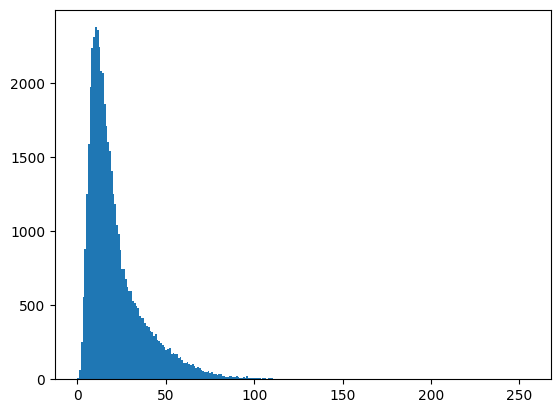

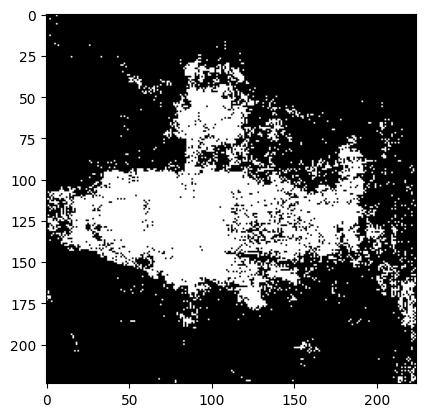

20.387402534484863


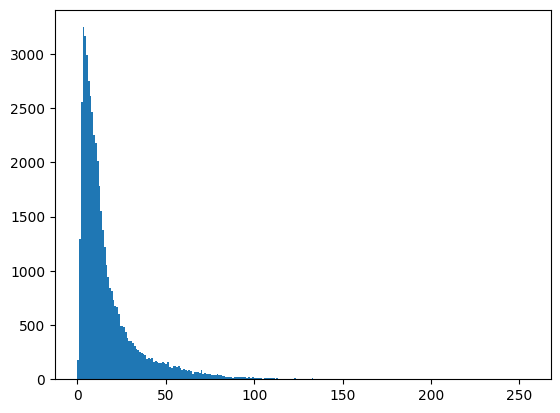

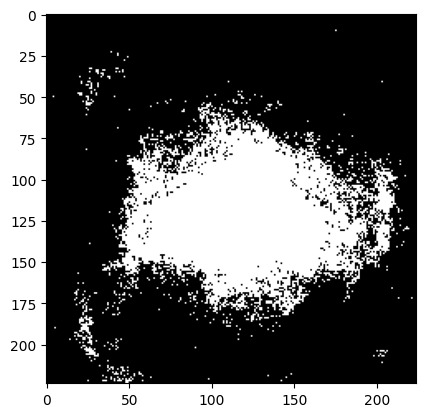

In [63]:
# for j in range(len(list_of_dir)):
for j in range(1):
  list_of_names = os.listdir(image_path+'/'+str(list_of_dir[j]))
  list_of_names.sort()
  original_image_array = list()

  for img_name in list_of_names:
    # Load the image
    image = Image.open(image_path+'/'+str(list_of_dir[j])+'/'+img_name)

    # Convert the image to a numpy array
    original_image_array.append(np.array(image))

  resized_image_array = list()
  for img in original_image_array:
    resized_image_array.append(change_size_for_model(img))

  resized_image_array = np.array(resized_image_array)

  ################
  # Your code

  result = model.predict(resized_image_array)
  saliency_map = list()
  for i in range(resized_image_array.shape[0]):
    X = resized_image_array[i]

    score = CategoricalScore([np.argmax(result[i])])

    saliency_map.append(saliency(score, X.astype(np.float32),smooth_samples=20,smooth_noise=0.10))
    # plt.imshow(saliency_map[i].reshape(224,224), cmap='gray')
    # plt.show()
    # plt.pause(1)

  ################

  folder_for_exp = SG_path + str(list_of_dir[j])
  if not os.path.exists(folder_for_exp):
      # The folder does not exist, so create it
      os.makedirs(folder_for_exp, exist_ok=True)
      print(f"Folder '{folder_for_exp}' was created.")
  else:
      # The folder already exists
      print(f"Folder '{folder_for_exp}' already exists.")

  for i in range(len(saliency_map)):
    a = 255*saliency_map[i].reshape(224,224)
    #print(a.shape)
    plt.figure()
    plt.hist(a.flatten(), bins=256, range=(0, 255))
    mod = np.percentile(a.flatten(),75)
    print(mod)
    a[np.where(a >= mod)] = 255
    a[np.where(a < mod)] = 0

    plt.figure()
    plt.imshow(a, cmap='binary_r')
    plt.show()
    plt.pause(1)
    plt.imsave(folder_for_exp+'/' +str(list_of_names[i]), a, cmap='binary_r')


GradCAM

In [64]:
# for j in range(len(list_of_dir)):
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

gradcam = Gradcam(model,
                  model_modifier=model_modifier_function,
                  clone=True)

for j in range(10):
  list_of_names = os.listdir(image_path+'/'+str(list_of_dir[j]))
  list_of_names.sort()
  original_image_array = list()

  for img_name in list_of_names:
    # Load the image
    image = Image.open(image_path+'/'+str(list_of_dir[j])+'/'+img_name)

    # Convert the image to a numpy array
    original_image_array.append(np.array(image))

  resized_image_array = list()
  for img in original_image_array:
    resized_image_array.append(change_size_for_model(img))

  resized_image_array = np.array(resized_image_array)

  ################
  # Your code

  result = model.predict(resized_image_array)
  saliency_map = list()
  for i in range(resized_image_array.shape[0]):
    X = resized_image_array[i]
    score = CategoricalScore([np.argmax(result[i])])
    print(np.argmax(result[i]))

    cam = gradcam(score,
              X.astype(np.float32),
              penultimate_layer=-1)
    heatmap = np.uint8(cm.jet(cam[0])* 255)
    plt.figure()
    plt.imshow(X, cmap='gray')
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.show()
    saliency_map.append(cam)
    # plt.imshow(saliency_map[i].reshape(224,224), cmap='gray')
    # plt.show()
    # plt.pause(1)

  ################

  folder_for_exp = SG_path + str(list_of_dir[j])
  if not os.path.exists(folder_for_exp):
      # The folder does not exist, so create it
      os.makedirs(folder_for_exp, exist_ok=True)
      print(f"Folder '{folder_for_exp}' was created.")
  else:
      # The folder already exists
      print(f"Folder '{folder_for_exp}' already exists.")

  for i in range(len(saliency_map)):
    a = 255*saliency_map[i].reshape(224,224)
    #print(a.shape)
    plt.figure()
    plt.hist(a.flatten(), bins=256, range=(0, 255))
    mod = np.percentile(a.flatten(),75)
    print(mod)
    # a[np.where(a >= mod)] = 255
    # a[np.where(a < mod)] = 0

    plt.figure()
    plt.imshow(a, cmap='binary_r')
    plt.show()
    plt.pause(1)
    plt.imsave(folder_for_exp+'/' +str(list_of_names[i]), a, cmap='binary_r')

Output hidden; open in https://colab.research.google.com to view.